# **NUMERICAL COMPUTATIONS FOR THE EXTENDED SIAM**

<hr style="border:4px solid skyblue">

## **HOUSEKEEPING STUFF**
<hr style="border:2px solid skyblue">

In [1]:
%load_ext autoreload
%autoreload 2
    
#### IMPORTS ####

from tqdm import tqdm
from math import sqrt
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from qutip import *
import time
from rgFlowGenerators import *
from phaseDiagram import *
from eigenSolver import *
from correlations import *
from spectralFunction import *
from plotting import *


#### GLOBAL PARAMETERS ####

global DELTA_D
DELTA_D = 0.1

def flatDOS(D0, D):
    return 1/D0

def semiEllDOS(D0, D):
    return 2 * np.sqrt(1 - D**2 / D0**2) / (np.pi * D0)
    

#### STYLE MODIFICATIONS FOR PLOTTING FIGURES ####
plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 25,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 10,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "gray",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 30,
                    })
linestyles = ["-", "--", ":"]
ggplotCmap = colors.ListedColormap(cols)
normGgplotCmap = colors.BoundaryNorm(range(len(cols)), ggplotCmap.N)

## **RENORMALISATION GROUP FLOWS FOR $J$, $V$ AND $U$**
<hr style="border:2px solid skyblue">

In [ ]:
def plot_rgflows_Ub(args):
    D0 = args["D0"]
    J0 = D0 * args["J0_by_D0"]
    V0 = J0 * args["V0_by_J0"]
    Ub_range = J0 * args["Ub_by_J_range"]
    fig, ax = plt.subplots(1,3,figsize=(22,6))
    for j,Ub in enumerate(Ub_range):
        U0 = -Ub * args["U_by_Ub"]
        E, U, V, J = complete_RG(D0, DELTA_D, flatDOS, U0, V0, J0, Ub=Ub)
        steps = E/D0
        label = r"$r={:.1f}r_c$".format(-4 * Ub/J0)
        for i,ylabel in enumerate([r"$U/U_0$", r"$J/J_0$", r"$V/V_0$"]):
            y_arr = [U,J,V][i] / [U[0], J[0], V[0]][i] if [U[0], J[0], V[0]][i] !=0 else [U,J,V][i]
            ax[i].plot(steps, y_arr, label=label, ls=linestyles[j%3])
            ax[i].legend(handlelength=2)
            ax[i].set_ylabel(ylabel)
            ax[i].set_xlabel(r"IR  $\longleftarrow$  RG flow  $\longleftarrow$  UV")
    plt.savefig("rg-flows-all.pdf", bbox_inches='tight')
    plt.show()


plot_rgflows_Ub({"D0": 1, 
                 "J0_by_D0": 0.2,
                 "V0_by_J0": 1,
                 "U_by_Ub": 120,
                 "Ub_by_J_range": -0.25 * np.array([0.1, 0.6, 0.99, 1.1]),
                }
               )

## **PHASE DIAGRAM OF THE e-SIAM**
<hr style="border:2px solid skyblue">

In [ ]:
def plotPhaseMap():
    phaseData, x_lims, y_lims, rc1_analytical, x_range = get_phasemap({"D0": 1, "DELTA_D": DELTA_D, "energyDOS": flatDOS, 
                                              "num_points": 150, "J0_by_D0_log10_lims": (0.065, 0.35),
                                              "r_log10_lims": (0, 0.4), "V_by_J": 0.8, "U_by_Ub": 130})
    print(np.unique(phaseData))
    plt.imshow(phaseData, origin="lower", extent=(*x_lims, *y_lims), aspect="auto", cmap=ggplotCmap, norm=normGgplotCmap)
    plt.plot(x_range, rc1_analytical, ls="--", color=cols[4], lw=3, label="$r=r_{c1}$")
    
    for i,label in enumerate([r"$J-V$", r"$J-U_b$", r"$U-U_b$", "dead", r"$V$"]):
        if i in np.unique(phaseData): plt.scatter([], [], marker="s", label=label, color=cols[i], s=200)
        
    
    plt.xlabel(r"$J_0/D_0$")
    plt.ylabel(r"$r=-U_b/J$")
    plt.axhline(0.25, 0, 1, color=cols[3], lw=3, ls="--", label="$r=r_{c2}$")
    plt.legend(loc="center right")
    plt.savefig("phase-map-MIT.pdf", bbox_inches='tight')
    plt.show()

plotPhaseMap()

## **EXCITED STATE DESCRIPTORS, ABOUT $U_{c1}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_excited_corrs_rc1(args):
    D0 = args["D0"]
    J0 = D0 * args["J0_by_D0"]
    V0 = J0 * args["V0_by_J0"]
    Ub_range = -np.linspace(min(args["Ub_lims"]), max(args["Ub_lims"]), args["num_points"])
    num_sites = args["num_sites"]
    results = []
    rc1_not_set_flag = True
    for Ub in tqdm(Ub_range):
        U0 = -args["U0_by_Ub"] * Ub
        E, U, V, J = complete_RG(D0, DELTA_D, flatDOS, U0, V0, J0, Ub)
        if rc1_not_set_flag and V[-1] < V[0]:
            rc1_value = -Ub/J0
            rc1_not_set_flag = False
        quants = get_excited_corrs((U[-1], V[-1], J[-1], Ub, args["hopping"], num_sites))
        results.append(quants)

    ylabels = [r"$I(d:0)$", r"$I(0:1)$", 
               r"$|\braket{c^\dagger_{0 \uparrow}c_{1  \uparrow}}|$",
               r"$2|\braket{c^\dagger_{d \uparrow}c_{0  \uparrow}}|$", 
               r"$|\frac{1}{2}\braket{S_0^+ S_1^- + \text{h.c.}}|$",
               r"$|\frac{1}{2}\braket{C_0^+ C_1^- + \text{h.c.}}|$",
               r"$\frac{1}{2}\braket{S_0^+ S_2^- + \text{h.c.}}$",
               r"$-\frac{1}{2}\braket{C_0^+ C_2^- + \text{h.c.}}$",
               r"$\frac{1}{2}\braket{S_0^+ S_3^- + \text{h.c.}}$",
               r"$-\frac{1}{2}\braket{C_0^+ C_3^- + \text{h.c.}}$",
               r"$4 I(d:1)$",r"$50 I(d:2)$",r"$I(d:3)$",
               r"$|\braket{c^\dagger_{0 \uparrow}c_{2  \uparrow}}|$",
               r"$2|\braket{c^\dagger_{0 \uparrow}c_{3  \uparrow}}|$",
              ]
        
    I_di = [np.array([r["mutinfo_di"][i] for r in results]) for i in range(num_sites)]
    I_0i = [np.array([r["mutinfo_0i"][i] for r in results]) for i in range(num_sites-1)]
    one_p_0i = [np.array([r["1p_0i"][i] for r in results]) for i in range(num_sites-1)]
    one_p_d0 = np.array([r["1p_d0"] for r in results])
    spin_flip_0i = [np.array([r["spin_flip_0i"][i] for r in results]) for i in range(num_sites-1)]
    charge_flip_0i = [np.array([r["charge_flip_0i"][i] for r in results]) for i in range(num_sites-1)]
    
    please_plot(-Ub_range/rc1_value, [I_di[0], I_di[1], 10*I_di[2]],
                    [r"$I(d:0)$", r"$I(d:1)$", r"$10\times I(d:2)$"],
                    r"mutual information",
                    r"$r/r_{c1}$",
                    "Uc1-mutinfo.pdf")
                     
    please_plot(-Ub_range/rc1_value, [I_0i[0], 4*I_0i[1], 4*I_0i[2]],
                    [r"$I_{01}$",
                     r"$4I_{02}$",
                     r"$4I_{03}$"],
                    r"mutual information",
                    r"$r/r_{c1}$",
                    "Uc1-bath-mutinfo.pdf")
    
    please_plot(-Ub_range/rc1_value, [one_p_0i[0], 2*one_p_d0, 2*one_p_0i[2]],
                    [r"$|\braket{c^\dagger_{0 \uparrow}c_{1  \uparrow}}|$",
                     r"$2|\braket{c^\dagger_{d \uparrow}c_{0  \uparrow}}|$",
                     r"$2|\braket{c^\dagger_{0 \uparrow}c_{3  \uparrow}}|$"],
                    r"1-particle correlations",
                    r"$r/r_{c1}$",
                    "Uc1-1p.pdf")
    
    please_plot(-Ub_range/rc1_value, [spin_flip_0i[0], charge_flip_0i[0]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_1^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_1^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-01.pdf")
    
    please_plot(-Ub_range/rc1_value, [spin_flip_0i[1], charge_flip_0i[1]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_2^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_2^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-02.pdf")
    
    please_plot(-Ub_range/rc1_value, [spin_flip_0i[2], charge_flip_0i[2]],
                    [r"$|\frac{1}{2}\braket{S_0^+ S_3^- + \text{h.c.}}|$",
                     r"$|\frac{1}{2}\braket{C_0^+ C_3^- + \text{h.c.}}|$"],
                    r"spin/charge correlations",
                    r"$r/r_{c1}$",
                    "Uc1-spin-charge-03.pdf")

    

get_excited_corrs_rc1({"D0": 10,
                       "J0_by_D0": 0.1,
                       "V0_by_J0": 1,
                       "U0_by_Ub": 120,
                       "Ub_lims": (0.158, 0.164),
                       "hopping": 0.1, 
                       "num_points": 40,
                       "num_sites": 4})

## **GROUND-STATE DESCRIPTORS, OVER FULL RANGE**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_over_range(args):
    D0 = args["D_0"]
    t = args["hop"]
    num_sites = args["num_sites"]
    Ub_min, Ub_max = args["Ub_lims"]
    num_points = args["num_points"] 
    J0 = D0 * args["J_by_D"]
    V0 = J0 * args["V_by_J"]
    U_by_Ub = args["U_by_Ub"]
    
    Ub_range = -(J0/4)*np.linspace(Ub_min, Ub_max, num_points)
    x_vals = -Ub_range/J0
    
    non_inter_args = {"couplings": (D0, DELTA_D, flatDOS, V0, J0, U_by_Ub), "sys_params": (t, num_sites)}
    args = [(Ub, non_inter_args) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations, args), total=num_points))
    
    SS                  = [r["SS_weight"] for r in results]
    CT                  = [r["CT_weight"] for r in results]
    LM                  = [r["LM_weight"] for r in results]
    xi_SS               = [r["geo_ent_ss"] for r in results]
    xi_CT               = [r["geo_ent_ct"] for r in results]
    QFI_spin            = [r["QFI_spinflip"] for r in results]
    QFI_charge          = [r["QFI_charge"] for r in results]
    QFI_Sdz             = [r["QFI_Sdz"] for r in results]
    spin_flip_corr_di   = [[r["spinflip_corr_di"][i] for r in results] 
                           for i,e in enumerate(results[0]["spinflip_corr_di"])]
    charge_flip_corr_0i = [[r["chargeflip_corr_01"][i] for r in results] 
                           for i,e in enumerate(results[0]["chargeflip_corr_01"])]
    charge_flip_corr_d0 = [r["chargeflip_corr_d0"] for r in results]
    I_01                = [r["mutinfo_01"] for r in results]
    I_di                = [[r["mutinfo_di"][i] for r in results] 
                           for i,e in enumerate(results[0]["mutinfo_di"])]
    doub_occ    = [[r["doub_occ"][i] for r in results] 
                           for i,e in enumerate(results[0]["doub_occ"])]
    
    please_plot(x_vals, [LM, SS, CT, doub_occ[0]],
                    [r"$|\braket{\text{LM}|\Psi_\text{gs}}|$",
                     r"$|\braket{\text{SS}|\Psi_\text{gs}}|$",
                     r"$|\braket{\text{CT}|\Psi_\text{gs}}|$",
                     r"$\braket{\hat n_{d \uparrow}\hat n_{d \downarrow}}$"],
                    r"ground-state overlaps", r"$r$",
                    "corrs_gs.pdf", logx=False, logy=False)
    
    please_plot(x_vals, [xi_CT, xi_SS],
                    [r"$\varepsilon_\text{ct}$",
                     r"$\varepsilon_\text{ss}$"],
                    r"geometric entanglement", r"$r$",
                    "entanglement.pdf", logx=False, logy=False)
    
    please_plot(x_vals, [QFI_spin, QFI_Sdz, QFI_charge],
                    [r"$\hat O=S_d^+S_0^- + \text{h.c.}$",
                     r"$\hat O=S_d^z$",
                     r"$\hat O=C_0^+ C_1^- + \text{h.c.}$"],
                    r"$F_Q(\Psi_\text{gs}, \hat O)$", r"$r$",
                    "QFI.pdf", logx=False, logy=False)
    
    please_plot(x_vals, [spin_flip_corr_di[0], charge_flip_corr_0i[0],
                             charge_flip_corr_d0],
                    [r"$-\frac{1}{2}\braket{S_d^+ S_0^- + \text{h.c.}}$",
                     r"$\frac{1}{2}\braket{C_0^+ C_1^- + \text{h.c.}}$",
                     r"$\frac{1}{2}\braket{C_d^+ C_0^- + \text{h.c.}}$"],
                    r"spin/charge correlations", r"$r$",
                    "spin-charge-corr-full.pdf", logx=False, logy=False)
    
    please_plot(x_vals, [I_01, I_di[0]],
                    [r"$I_2(0:1)$", r"$I_2(d:0)$"],
                    r"mutual information", r"$r$",
                    "mutinfo-d0-01-full.pdf", logx=False, logy=False)


args = {"D_0": 10,
        "hop": 0.1,
        "J_by_D": 0.15,
        "V_by_J": 1,
        "U_by_Ub": 100,
        "Ub_lims": (0.16, 1.2),
        "num_sites": 5,
        "num_points": 40}
get_correlations_over_range(args)

## **GROUND-STATE DESCRIPTORS, NEAR $r_{c2}$**
<hr style="border:2px solid skyblue">

In [ ]:
def plot_correlations_near_transition(t, D0, J0_by_D0, Ub_lims, num_points, num_sites):
    x_arr, results = get_correlations_near_transition(t, D0, DELTA_D, flatDOS, J0_by_D0, Ub_lims, num_points, num_sites)
    charge_flip_corr_0i = results["charge_flip_corr_0i"]
    spin_flip_corr_di = results["spin_flip_corr_di"]
    I_0i = results["I_0i"]
    I_di = results["I_di"]
    I_d01 = results["I_d01"]
    spin_spin_corr_di = results["spin_spin_corr_di"]
    charge_flip_corr_0i = results["charge_flip_corr_0i"]
    charge_ising_corr_0i = results["charge_ising_corr_0i"]
    spin_ising_corr_di = results["spin_ising_corr_di"]
    charge_charge_corr_0i = results["charge_charge_corr_0i"]
    density_corr_00 = results["density_corr_00"]
    imp_EE = results["imp_EE"]
    QFI_sf, QFI_ch, QFI_sd = results["QFI"]

    # plot d-0 spin-flip and 0-1 charge flip correlations
    please_plot(x_arr, 
                    (charge_flip_corr_0i[0],),
                    [r"$\braket{C_0^+ C_1^-}$",],
                    r"charge correlation",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-corr.pdf",
                    logx=True)    
    please_plot(x_arr, 
                    (-spin_flip_corr_di[0],),
                    [r"$-\braket{S_d^+ S_0^-}$",],
                    r"spin correlation",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-corr.pdf",
                    logx=True)      

    # plot spin-flip correlations - d i, i > 0
    please_plot(x_arr, 
                    (5*np.abs(spin_flip_corr_di[1]),
                     np.abs(spin_flip_corr_di[2]),
                     30*np.abs(spin_flip_corr_di[3]),
                     np.abs(spin_flip_corr_di[4]),),
                    [r"$5|\braket{S_d^+ S_1^-}|$",
                     r"$|\braket{S_d^+ S_2^-}|$",
                     r"$30|\braket{S_d^+ S_3^-}|$",
                     r"$|\braket{S_d^+ S_4^-}|$"],
                    r"spin/charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-flip-di.pdf",
                    logx=True)   


    # plot mutual/trip. info - d1 & d01
    please_plot(x_arr, (I_0i[0], I_di[0], 500*I_di[1], 5*I_d01),
                    [r"$I_2(0:1)$", r"$I_2(d:0)$",
                     r"$500 I_2(d:1)$", r"$5 I_3(d:0:1)$"],
                    r"mutual/tripartite information",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-mut-trip-info.pdf",
                    logx=True)       



    # plot mutual info 0i
    please_plot(x_arr, 
                    (I_0i[0],
                     3*I_0i[1],
                     5*I_0i[2],
                     5*I_0i[3]),
                    [r"$I_2(0:1)$",
                     r"$3I_2(0:2)$",
                     r"$5I_2(0:3)$",
                     r"$5I_2(0:4)$",],
                    r"bath mutual information",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-mut-info-bath.pdf",
                    logx=True)  


    # plot spin-spin correlation - d0
    please_plot(x_arr, 
                    (spin_spin_corr_di[0], 3*spin_ising_corr_di[0]),
                    [r"$\braket{\vec S_d \cdot \vec S_0}$",
                     r"$3\braket{S_d^z S_0^z}$"],
                    r"spin correlations: $d-0$",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-corr-d0.pdf",
                    logx=True)  


    # plot spin-spin correlations - di
    please_plot(x_arr, 
                    (5*np.abs(spin_spin_corr_di[1]),
                     np.abs(spin_spin_corr_di[2]),
                     20*np.abs(spin_spin_corr_di[3]),
                     np.abs(spin_spin_corr_di[4]),),
                    [r"$5|\braket{{\vec S_d \cdot \vec S_1}}|$",
                     r"$|\braket{{\vec S_d \cdot \vec S_2}}|$",
                     r"$20|\braket{{\vec S_d \cdot \vec S_3}}|$",
                     r"$|\braket{{\vec S_d \cdot \vec S_4}}|$"],
                    r"imp.-bath spin correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spinspin-corr-di.pdf",
                    logx=True) 


    # plot charge-flip correlations - 0i
    please_plot(x_arr, 
                    (np.abs(charge_flip_corr_0i[0]),
                     3*np.abs(charge_flip_corr_0i[1]),
                     10*np.abs(charge_flip_corr_0i[2]),
                     4*np.abs(charge_flip_corr_0i[3]),),
                    [r"$|\braket{C_0^+ C_1^-}|$",
                     r"$3|\braket{C_0^+ C_2^-}|$",
                     r"$10|\braket{C_0^+ C_3^-}|$",
                     r"$4|\braket{C_0^+ C_4^-}|$"],
                    r"bath charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-flip-corr-0i.pdf",
                    logx=True)


    # plot charge-ising correlations - 0i
    please_plot(x_arr, 
                    (charge_ising_corr_0i[0],
                     3*charge_ising_corr_0i[1],
                     10*charge_ising_corr_0i[2],
                     3*charge_ising_corr_0i[3],),
                    [r"$\braket{C_0^z C_1^z}$",
                     r"$3\braket{C_0^z C_2^z}$",
                     r"$10\braket{C_0^z C_3^z}$",
                     r"$3\braket{C_0^z C_4^z}$"],
                    r"bath CDW correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-ising-corr-0i.pdf",
                    logx=True)


    # plot spin-ising correlations - di
    please_plot(x_arr, 
                    (5*np.abs(spin_ising_corr_di[1]),
                     np.abs(spin_ising_corr_di[2]),
                     20*np.abs(spin_ising_corr_di[3]),
                     np.abs(spin_ising_corr_di[4]),),
                    [r"$5|\braket{S_d^z S_1^z}|$",
                     r"$|\braket{S_d^z S_2^z}|$",
                     r"$20|\braket{S_d^z S_3^z}|$",
                     r"$|\braket{S_d^z S_4^z}|$"],
                    r"Ising correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-spin-ising-corr-di.pdf",
                    logx=True)


    # plot charge-charge correlations - 0i
    please_plot(x_arr, 
                    (np.abs(charge_charge_corr_0i[0]),
                     np.abs(charge_charge_corr_0i[1]),
                     10*np.abs(charge_charge_corr_0i[2]),
                     np.abs(charge_charge_corr_0i[3]),),
                    [r"$|\braket{{\vec C_0 \cdot \vec C_1}}|$",
                     r"$|\braket{{\vec C_0 \cdot \vec C_2}}|$",
                     r"$10|\braket{{\vec C_0 \cdot \vec C_3}}|$",
                     r"$|\braket{{\vec C_0 \cdot \vec C_4}}|$"],
                    r"bath charge correlations",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-charge-charge-corr-0i.pdf",
                    logx=True)

    # plot QFI
    please_plot(x_arr, 
                    (0.9 * QFI_sf, QFI_sd, QFI_ch),
                    [r"$\hat O=S_d^+S_0^- + \text{h.c.}$",
                     r"$\hat O=S_d^z$",
                     r"$\hat O=C_0^+ C_1^- + \text{h.c.}$"],
                    r"$F_Q(\Psi_\text{gs}, \hat O)$",
                    r"$(r_{c2} - r)^{-1}$",
                    "rc2-QFI.pdf",
                    logx=True)

plot_correlations_near_transition(0.1, 10, 0.15, (0, -3), 40, 5)

## **GROUND-STATE DESCRIPTORS, *ABOUT* $r_{c2}$**
<hr style="border:2px solid skyblue">

In [ ]:
def get_correlations_across_transition(args):
    t = args["hopping"]
    D0 = args["bandwidth"]
    J0_by_D0 = args["J_by_bwidth"]
    num_points = args["num_points"]
    num_sites = args["num_sites"]
    save_fig = args["save_fig"]
    J0 = D0 * J0_by_D0
    Ub_lims = args["Ub_lims"]
    Ub_range = -0.25 * J0 * (1 + np.linspace(Ub_lims[0], Ub_lims[1], num_points))
    args = [(num_sites, t, D0, DELTA_D, flatDOS, J0, Ub) for Ub in Ub_range]
    num_threads = 40 if num_sites < 5 else 2

    results = list(tqdm(Pool(num_threads).imap(get_gstate_correlations_J_Ub, args), total=len(Ub_range)))
    x_arr = -Ub_range/J0
    charge_flip_corr_0i = [np.array([r["charge_flip_corr_0i"][i] for r in results])
                           for i in range(num_sites-1)]
    I_0i = [np.array([r["I_0i"][i] for r in results])
            for i in range(num_sites-1)]
    I_di = [np.array([r["I_di"][i] for r in results])
            for i in range(num_sites)]
    I_d01 = np.array([r["I_d01"] for r in results])

    please_plot(x_arr, charge_flip_corr_0i[0],
                    [],
                    r"$\frac{1}{2}\braket{{C_0^+ C_1^- + \text{h.c.}}}$",
                    r"$r$",
                    "charge-flip-01-across.pdf",
                    )
  
    
    please_plot(x_arr, [I_di[0], I_0i[0]],
                    [r"$I_2(d:0)$",
                    r"$I_2(0:1)$"],
                    r"imp. \& bath mutual info.",
                    r"$r$",
                    "mut-info-d0-01-across.pdf",
                    )
    
    
    please_plot(x_arr, [100*I_di[1], I_d01],
                    [r"$100\times I_2(d:1)$", r"$I_3(d:0:1)$"],
                    r"Mut. \& tripartite info.",
                    r"$r$",
                    "trip-info-across.pdf",
                    )
    

get_correlations_across_transition({"hopping": 0.1,
                                    "bandwidth": 10,
                                    "J_by_bwidth": 0.1,
                                    "Ub_lims": (-0.001, 0.001),
                                    "num_points": 40,
                                    "num_sites": 5,
                                    "save_fig": True})

## **BEHAVIOUR OF THE IMPURITY SPECTRAL FUNCTION**
<hr style="border:2px solid skyblue">

In [2]:
def plot_spec_func(args):
    D0 = args["D0"]
    J0 = D0 * args["J0_by_D0"]
    V0 = args["V0_by_J0"] * J0
    num_points = args["num_points"]
    eta_delta = args["eta_delta"]
    use_guess = args["use_guess"]
    no_Ub = args["no_Ub"]
    omega_end = args["omega_end"]
    
    target_height = 1
    for i, (factor, broad_guess) in tqdm(enumerate(zip(args["factor_arr"], args["broad_guess_arr"])), total=len(args["broad_guess_arr"])):
        if no_Ub == False:
            Ub = -J0 * factor
            U0 = -args["U_by_Ub"] * Ub
            label = r"$r={:.2f}r_c$".format(4*factor)
        else:
            U0 = factor
            Ub = 0
            label = r"$U/\Delta={:.2f}$".format(U0/(np.pi * V0))
        omega_arr_full, spec_func_norm = full_spec_func(V0, J0, U0, D0, DELTA_D, flatDOS, Ub, num_points, args["num_sites"], target_height, broad_guess, eta_delta, use_guess)
        if U0 == 0 and Ub == 0:
            target_height = spec_func_norm[omega_arr_full >= 0][0]
        plt.plot(omega_arr_full[abs(omega_arr_full) < omega_end], spec_func_norm[abs(omega_arr_full) < omega_end], 
                 label=label, lw=6, color=cols[i])

    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$A(\omega)$")
    plt.title(r"$D={:.2f}, J/D={:.2f}, V/J={:.2f}, U/Ub={:.2f}$"
              .format(args["D0"], args["J0_by_D0"], args["V0_by_J0"], args["U_by_Ub"]))
    plt.legend()
    plt.savefig("spectral-function-D={:.2f}_J_by_D={:.2f}_V_by_J={:.2f}_U_by_Ub={:.2f}.pdf"
                .format(args["D0"], args["J0_by_D0"], args["V0_by_J0"], args["U_by_Ub"]), bbox_inches='tight')
    plt.show()

  0%|                                                     | 0/6 [00:00<?, ?it/s]

0.616669537610582
0.4


 17%|███████▌                                     | 1/6 [00:06<00:34,  6.81s/it]

0.5187231411739659



0it [00:00, ?it/s]
U=2.25,broad=0.29475,inc=-0.07369,distance=0.56%: : 1it [00:00, 1950.84it/s]
U=2.25,broad=0.29475,inc=-0.07369,distance=0.56%: : 2it [00:12,  6.33s/it]  
U=2.25,broad=0.22106,inc=-0.07369,distance=0.56%: : 2it [00:12,  6.33s/it]
U=2.25,broad=0.22106,inc=-0.07369,distance=0.56%: : 3it [00:25,  8.95s/it]
U=2.25,broad=0.29475,inc=-0.00737,distance=27.07%: : 3it [00:25,  8.95s/it]
U=2.25,broad=0.29475,inc=-0.00737,distance=27.07%: : 4it [00:38, 10.49s/it]
U=2.25,broad=0.28738,inc=-0.00737,distance=0.56%: : 4it [00:38, 10.49s/it] 
U=2.25,broad=0.28738,inc=-0.00737,distance=0.56%: : 5it [00:50, 11.10s/it]
U=2.25,broad=0.29475,inc=-0.00074,distance=1.56%: : 5it [00:50, 11.10s/it]
U=2.25,broad=0.29475,inc=-0.00074,distance=1.56%: : 6it [01:03, 11.83s/it]
U=2.25,broad=0.29401,inc=-0.00074,distance=0.56%: : 6it [01:03, 11.83s/it]
U=2.25,broad=0.29401,inc=-0.00074,distance=0.56%: : 7it [01:17, 12.32s/it]
U=2.25,broad=0.29328,inc=-0.00074,distance=0.35%: : 7it [01:17, 12.32s/it

0.29253937499999993



 33%|███████████████                              | 2/6 [02:15<05:12, 78.24s/it]

0.5603964562568912



0it [00:00, ?it/s]
U=4.50,broad=0.08550,inc=0.02138,distance=60.81%: : 1it [00:00, 2154.24it/s]
U=4.50,broad=0.08550,inc=0.02138,distance=60.81%: : 2it [00:13,  6.54s/it]  
U=4.50,broad=0.10688,inc=0.02138,distance=60.81%: : 2it [00:13,  6.54s/it]
U=4.50,broad=0.10688,inc=0.02138,distance=60.81%: : 3it [00:25,  9.19s/it]
U=4.50,broad=0.12825,inc=0.02138,distance=30.54%: : 3it [00:25,  9.19s/it]
U=4.50,broad=0.12825,inc=0.02138,distance=30.54%: : 4it [00:39, 10.75s/it]
U=4.50,broad=0.14963,inc=0.02138,distance=10.30%: : 4it [00:39, 10.75s/it]
U=4.50,broad=0.14963,inc=0.02138,distance=10.30%: : 5it [00:52, 11.52s/it]
U=4.50,broad=0.12825,inc=0.00214,distance=4.15%: : 5it [00:52, 11.52s/it] 
U=4.50,broad=0.12825,inc=0.00214,distance=4.15%: : 6it [01:04, 11.83s/it]
U=4.50,broad=0.13039,inc=0.00214,distance=10.30%: : 6it [01:04, 11.83s/it]
U=4.50,broad=0.13039,inc=0.00214,distance=10.30%: : 7it [01:17, 12.23s/it]
U=4.50,broad=0.13252,inc=0.00214,distance=8.64%: : 7it [01:17, 12.23s/it] 
U=

0.14278500000000002



 50%|██████████████████████                      | 3/6 [07:12<08:54, 178.16s/it]

0.2744528201472532



0it [00:00, ?it/s]
U=6.75,broad=0.05188,inc=0.01297,distance=44.72%: : 1it [00:00, 2258.65it/s]
U=6.75,broad=0.05188,inc=0.01297,distance=44.72%: : 2it [00:12,  6.37s/it]  
U=6.75,broad=0.06485,inc=0.01297,distance=44.72%: : 2it [00:12,  6.37s/it]
U=6.75,broad=0.06485,inc=0.01297,distance=44.72%: : 3it [00:25,  9.07s/it]
U=6.75,broad=0.07782,inc=0.01297,distance=16.86%: : 3it [00:25,  9.07s/it]
U=6.75,broad=0.07782,inc=0.01297,distance=16.86%: : 4it [00:40, 11.13s/it]
U=6.75,broad=0.06485,inc=0.00130,distance=1.93%: : 4it [00:40, 11.13s/it] 
U=6.75,broad=0.06485,inc=0.00130,distance=1.93%: : 5it [00:53, 11.84s/it]
U=6.75,broad=0.06615,inc=0.00130,distance=16.86%: : 5it [00:53, 11.84s/it]
U=6.75,broad=0.06615,inc=0.00130,distance=16.86%: : 6it [01:06, 12.26s/it]
U=6.75,broad=0.06744,inc=0.00130,distance=14.66%: : 6it [01:06, 12.26s/it]
U=6.75,broad=0.06744,inc=0.00130,distance=14.66%: : 7it [01:19, 12.66s/it]
U=6.75,broad=0.06874,inc=0.00130,distance=12.54%: : 7it [01:19, 12.66s/it]
U=

0.07626360000000003



 67%|█████████████████████████████▎              | 4/6 [12:20<07:39, 229.75s/it]

0.29534307980799296
0.03195


 83%|████████████████████████████████████▋       | 5/6 [12:27<02:29, 149.21s/it]

0.2966168747490397
0.01


100%|████████████████████████████████████████████| 6/6 [12:33<00:00, 125.61s/it]


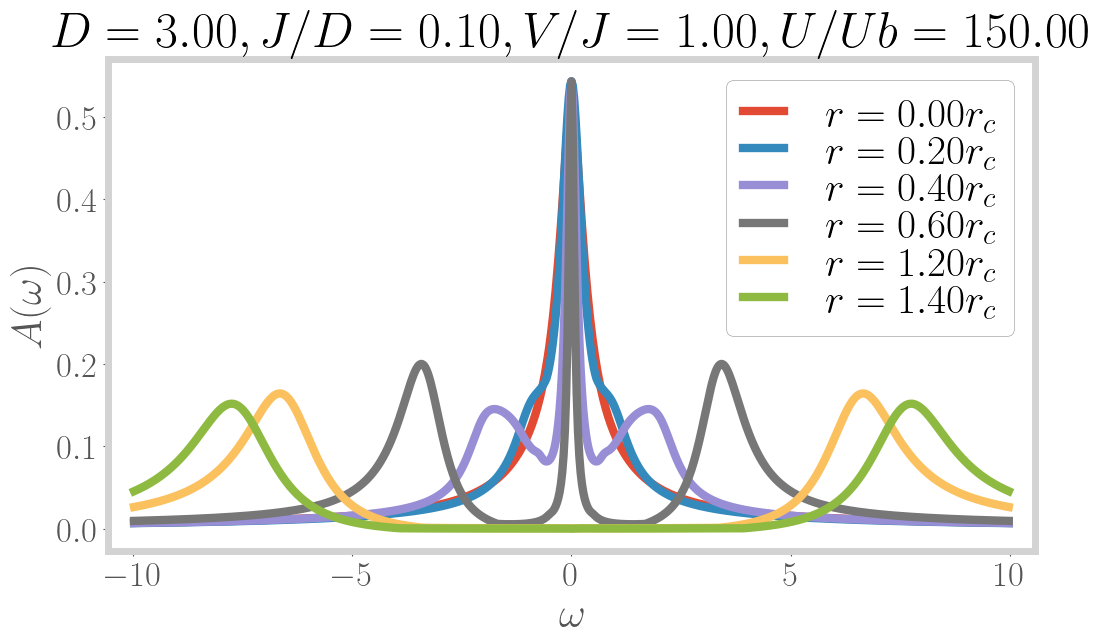

In [3]:
plot_spec_func({"D0": 3, "V0_by_J0": 1, "J0_by_D0": 0.1, "U_by_Ub": 150, 
                "factor_arr": [0, 0.05, 0.1, 0.15, 0.3, 0.35],
                "broad_guess_arr": [0.4, 0.29475, 0.08550, 0.05188, 0.03195, 0.01], 
                "num_sites": 2, "num_points": 500, "eta_delta": 0.3,
                "use_guess": False, "no_Ub": False, "omega_end": 10})